In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/unsupervised_aav2`


In [2]:
using JLD2, BSON, Flux, BiophysViabilityModel, PyPlot, BioSeqInt, Statistics, DensityPlot, LinearAlgebra, StringDistances,
    GaussianMixtures, Distributions

In [3]:
const PhageTree = BiophysViabilityModel

BiophysViabilityModel

In [4]:
include("../analysis/utils.jl")

binomial_threshold (generic function with 1 method)

In [6]:
using BiophysViabilityModel:Data

# Data

### experiments 1 and 2
### cnn data are filtered (<100 counts)

In [7]:
threshold_experiment1 = -1.4792505511322604

-1.4792505511322604

In [8]:
threshold_experiment2 = -0.1828115693971919

-0.1828115693971919

In [9]:
threshold_experiment3 = 1.2303188241388179

1.2303188241388179

In [10]:
sequences_experiment1, counts_experiment1, labels_experiment1 = 
    load_data_cnn("../my_data/data_experiment1.jld2", threshold_experiment1, "experiment1");

In [11]:
sequences_experiment2, counts_experiment2, labels_experiment2 = 
    load_data_cnn("../my_data/data_experiment2.jld2",threshold_experiment2, "experiment2");

In [12]:
plasmid_experiment1, virus_experiment1 = load_experiment_phagetree("../my_data/data_experiment1.jld2", "experiment1");

In [13]:
plasmid_experiment2, virus_experiment2 = load_experiment_phagetree("../my_data/data_experiment2.jld2", "experiment2");

In [14]:
data_experiments = Data(plasmid_experiment1, plasmid_experiment2);

In [15]:
sequences_experiment3, counts_experiment3, labels_experiment3 = 
    load_data_cnn("../my_data/data_experiment3.jld2", threshold_experiment3, "experiment3");

In [16]:
data_experiment3 = load_data_phagetree("../my_data/data_experiment3.jld2", "experiment3");

# log selectivity

In [17]:
θexperiment1 = [log(counts_experiment1[m,2] / counts_experiment1[m,1]) for m in axes(counts_experiment1, 1)];

In [18]:
θexperiment2 = [log(counts_experiment2[m,2] / counts_experiment2[m,1]) for m in axes(counts_experiment2, 1)];

In [19]:
θexperiment3 = [log(counts_experiment3[m,2] / counts_experiment3[m,1]) for m in axes(counts_experiment3, 1)];

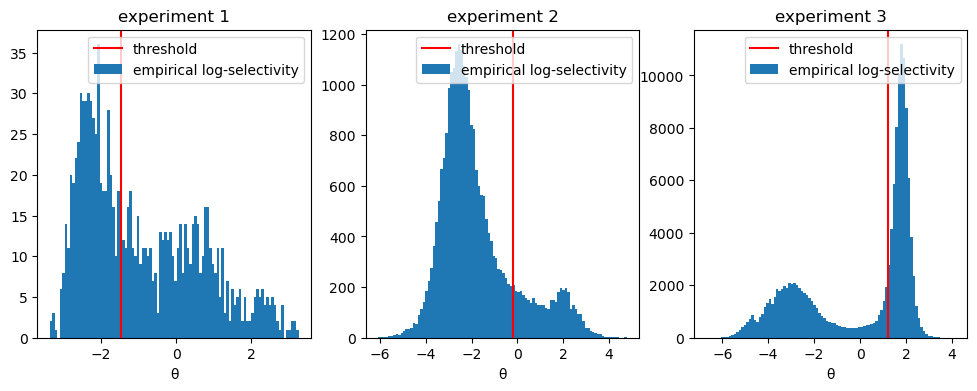

PyObject <matplotlib.legend.Legend object at 0x7fde18305e50>

In [20]:
fig, ax = subplots(1,3, figsize=(12,4))

ax[1].hist(filter(isfinite, θexperiment1), bins=100)
ax[1].axvline(threshold_experiment1, color="red")
ax[1].set_xlabel("θ")
ax[1].set_title("experiment 1")
ax[1].legend(["threshold", "empirical log-selectivity"])

ax[2].hist(filter(isfinite, θexperiment2), bins=100)
ax[2].axvline(threshold_experiment2, color="red")
ax[2].set_xlabel("θ")
ax[2].set_title("experiment 2")
ax[2].legend(["threshold", "empirical log-selectivity"])

ax[3].hist(filter(isfinite, θexperiment3), bins=100)
ax[3].axvline(threshold_experiment3, color="red")
ax[3].set_xlabel("θ")
ax[3].set_title("experiment 3")
ax[3].legend(["threshold", "empirical log-selectivity"])

# CNN

In [21]:
file_cnn = BSON.load("../cnn_models/train_experiment2_thrfit.bson")
model_cnn = file_cnn[:model]
history_cnn = file_cnn[:history]

MVHistory{ValueHistories.History}
  :training_loss => 200 elements {Int64,Float32}

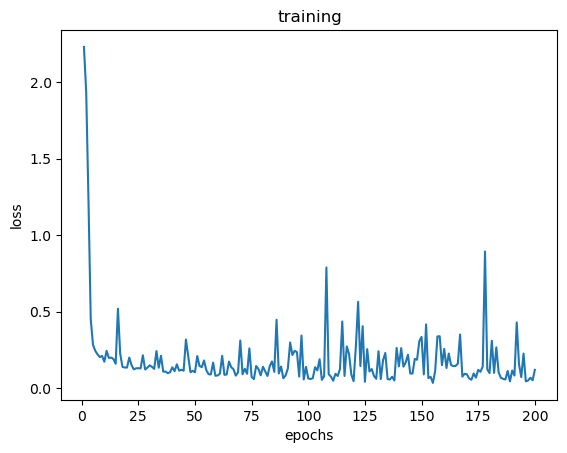

In [22]:
plot(get(history_cnn, :training_loss)...)
title("training")
xlabel("epochs")
ylabel("loss");

In [23]:
logits_experiment1 = model_cnn(sequences_experiment1) |> x -> x[2,:] .- x[1,:];

In [24]:
logits_experiment2 = model_cnn(sequences_experiment2) |> x -> x[2,:] .- x[1,:];

In [25]:
#since this line takes a lot of time you can just load them from the file "logits_experiment3.jld2"
#logits_experiment3 = model_cnn(sequences_experiment3) |> x -> x[2,:] .- x[1,:];
@load "logits_experiment3.jld2"

2-element Vector{Symbol}:
 :logits_experiment3
 :logits_experiment3_notfiltered

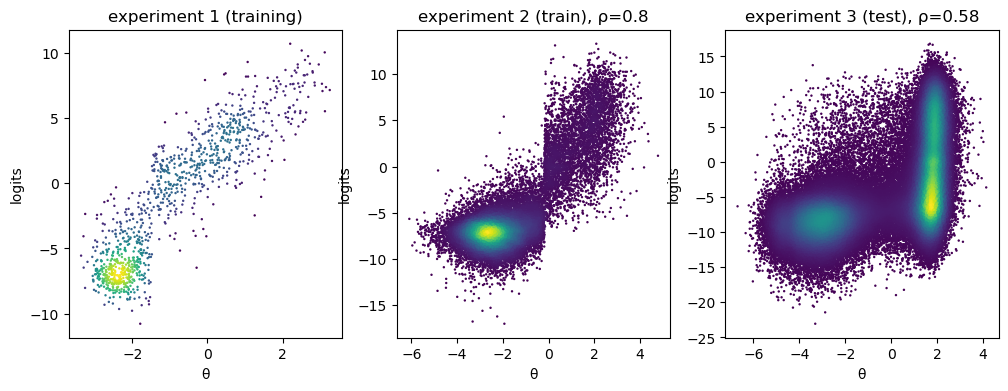

In [26]:
fig, ax = subplots(1,3, figsize=(12,4))

plot_density(θexperiment1, logits_experiment1, ax[1], filter=false)
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("logits");

plot_density(θexperiment2, logits_experiment2, ax[2], filter=true)
ax[2].set_title("experiment 2 (train), ρ=$(round(cor_sp(θexperiment2, logits_experiment2), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("logits");

plot_density(θexperiment3, logits_experiment3, ax[3], filter=true)
ax[3].set_title("experiment 3 (test), ρ=$(round(cor_sp(θexperiment3, logits_experiment3), digits=2))")
ax[3].set_xlabel("θ")
ax[3].set_ylabel("logits");

In [27]:
println("training accuracy on experiment 1: ",
compute_accuracy(logits_experiment1, 0.0, θexperiment1, threshold_experiment1))

training accuracy on experiment 1: 0.904147465437788


In [28]:
println("training accuracy on experiment 2: ",
compute_accuracy(logits_experiment2, 0.0, θexperiment2, threshold_experiment2))

training accuracy on experiment 2: 0.9558767880118065


In [29]:
println("testing accuracy on experiment 3: ",
compute_accuracy(logits_experiment3, 0.0, θexperiment3, threshold_experiment3))

testing accuracy on experiment 3: 0.6702504373053458


In [30]:
true_pos_cnn, false_pos_cnn = roc(logits_experiment3, θexperiment3, threshold_experiment3);

In [31]:
auc_val_cnn = auc(false_pos_cnn, true_pos_cnn) |> mean
println("AUC: ", auc_val_cnn)

AUC: 0.8374523213960289


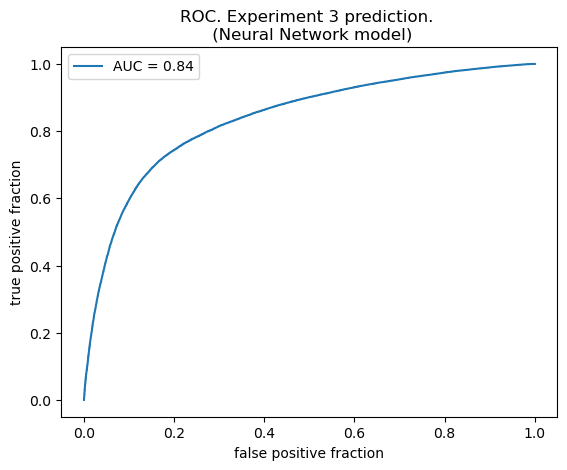

PyObject <matplotlib.legend.Legend object at 0x7fde0f6de1f0>

In [32]:
plot(false_pos_cnn, true_pos_cnn)
title("ROC. Experiment 3 prediction. \n (Neural Network model)")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_cnn, digits=2))"])

In [33]:
println("confusion matrix \n")
confusion_matrix(logits_experiment3, 0.0, θexperiment3, threshold_experiment3) 

confusion matrix 

TP: 33386	 FN: 42924
FP: 3450	 TN: 60874

(tpr = 0.43750491416590226, fpr = 0.05363472420869349)

# PhageTree

In [34]:
file_phagetree = BSON.load("../phagetree_models/train_experiment2_b256.bson")
model_pt = file_phagetree[:model]
history_pt = file_phagetree[:history]

MVHistory{ValueHistories.History}
  :loglikelihood_batch => 22000 elements {Int64,Float64}
  :loglikelihood => 200 elements {Int64,Float64}
  :epoch => 22000 elements {Int64,Int64}

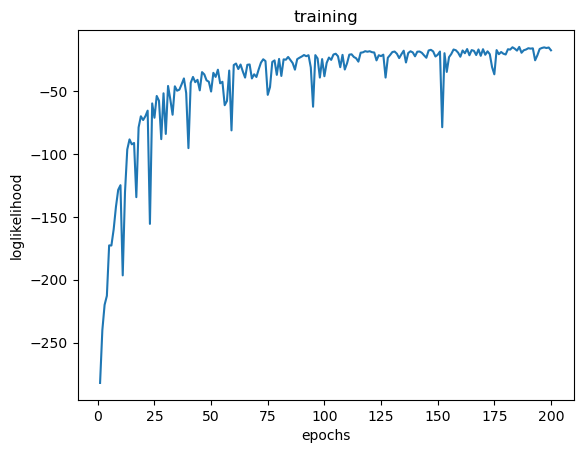

In [35]:
plot(get(history_pt, :loglikelihood)...)
title("training")
xlabel("epochs")
ylabel("loglikelihood");

In [36]:
ls_experiment12 = log_selectivities(model_pt, data_experiments)

27970×2 Matrix{Float64}:
 -4.12281   -4.81356
 -2.43175   -3.08547
 -4.62692   -5.32091
 -5.10279   -5.79865
 -1.9433    -2.56747
 -5.00451   -5.70006
 -5.46319   -6.15998
 -4.72291   -5.41736
 -3.24102   -3.92007
 -2.5307    -3.18876
 -3.10752   -3.7837
 -1.93573   -2.55931
 -0.69256   -1.10168
  ⋮         
 -5.1539    -5.84992
 -4.4672    -5.16034
 -5.14882   -5.84482
 -0.671077  -1.07287
 -5.2549    -5.95119
 -4.48307   -5.17629
 -0.439478  -0.746777
 -4.40025   -5.09298
 -5.52188   -6.21879
 -2.38265   -3.03405
 -4.61881   -5.31276
 -0.838723  -1.29254

In [37]:
idx_exp1 = findall((data_experiments.counts[:,1] .> 0).&&(data_experiments.counts[:,3] .== 0))
idx_exp2 = findall((data_experiments.counts[:,1] .== 0).&&(data_experiments.counts[:,3] .> 0))
idx_exp12 = findall((data_experiments.counts[:,1] .> 0).&&(data_experiments.counts[:,3] .> 0));

In [38]:
ls_experiments = zeros(size(ls_experiment12, 1))
for s in axes(ls_experiments, 1)
    if s in idx_exp1
        ls_experiments[s] = ls_experiment12[s,1]
    elseif s in idx_exp2
        ls_experiments[s] = ls_experiment12[s,2]
    elseif s in idx_exp12
        ls_experiments[s] = mean(ls_experiment12[s,:])
    else
        ls_experiments[s] = NaN
        println("NaN at index $s...")
    end
end

NaN at index 23260...


In [39]:
#since the following line takes a lot of time you can just load it from the file "logselectivities_exp3.jld2"
#ls_experiment3 = vec(log_selectivities(model_pt, data_experiment3)[:, 2]);
@load "logselectivities_exp3.jld2"
ls_experiment3_filtered = ls_experiment3[data_experiment3.counts[:, 1].>=100];

In [40]:
θexperiments_12 = log_selectivities(data_experiments);

In [41]:
θexperiments_pt = zeros(size(θexperiments_12, 1))
for s in axes(θexperiments_pt, 1)
    if s in idx_exp1
        θexperiments_pt[s] = θexperiments_12[s,1]
    elseif s in idx_exp2
        θexperiments_pt[s] = θexperiments_12[s,2]
    elseif s in idx_exp12
        θexperiments_pt[s] = mean(θexperiments_12[s,:])
    else
        θexperiments_pt[s] = NaN
        println("NaN at index $s...")
    end
end

NaN at index 23260...


In [42]:
#takes a lot of time and it is not useful
#θexperiment3_pt = vec(log_selectivities(data_experiment3));

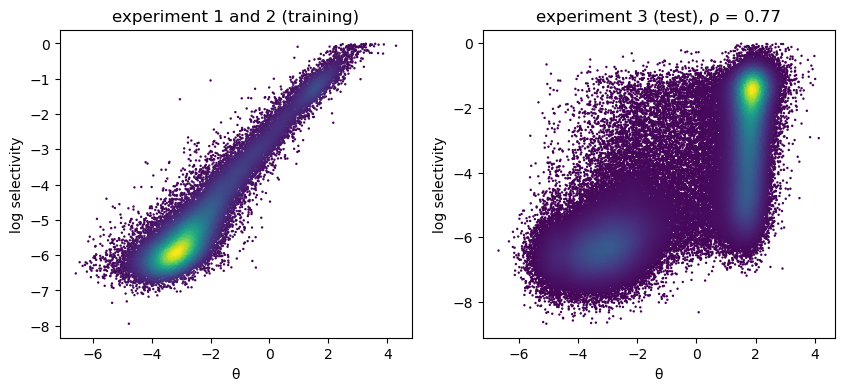

PyObject Text(446.72727272727263, 0.5, 'log selectivity')

In [43]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiments_pt, ls_experiments, ax[1], filter=true)
ax[1].set_title("experiment 1 and 2 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("log selectivity")

plot_density(θexperiment3, ls_experiment3_filtered, ax[2], filter=true)
ax[2].set_title("experiment 3 (test), ρ = $(round(cor_sp(θexperiment3, ls_experiment3_filtered), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("log selectivity")

In [44]:
true_pos_pt, false_pos_pt = roc(ls_experiment3_filtered, θexperiment3, threshold_experiment3);

In [45]:
auc_val_pt = auc(false_pos_pt, true_pos_pt) |> mean
println("AUC: ", auc_val_pt)

AUC: 0.9035601910117735


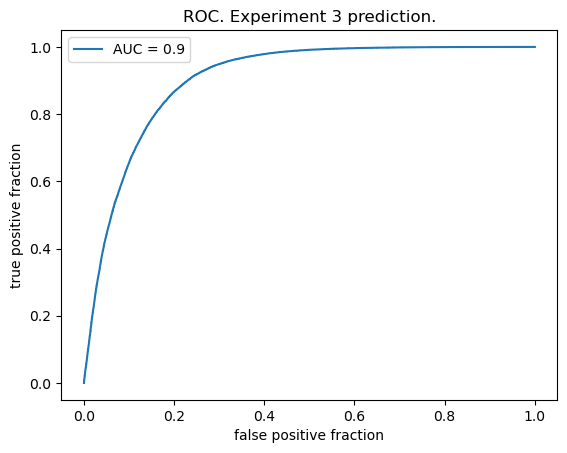

PyObject <matplotlib.legend.Legend object at 0x7fde18172a90>

In [46]:
plot(false_pos_pt, true_pos_pt)
title("ROC. Experiment 3 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_pt, digits=2))"])

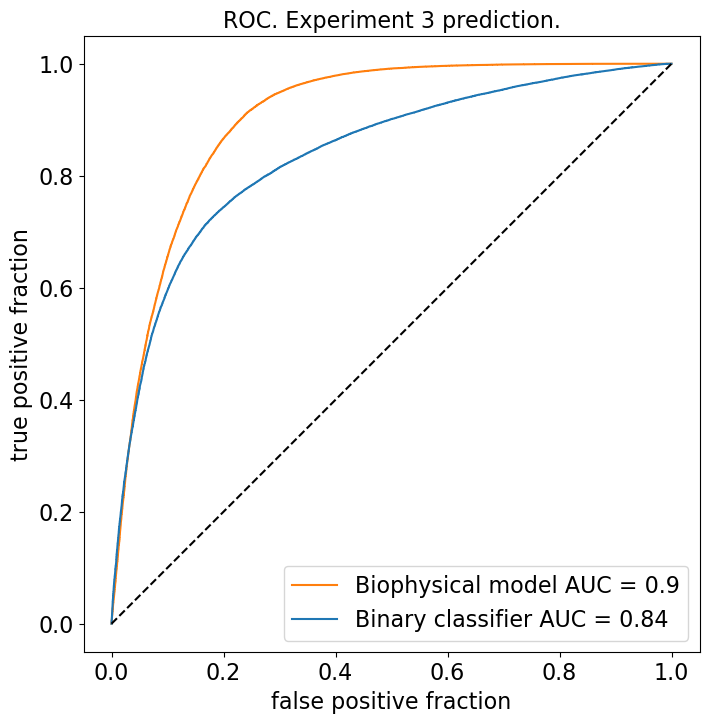

In [47]:
figure(figsize=(8,8))
plot(false_pos_pt, true_pos_pt, color="#ff7f0e")
plot(false_pos_cnn, true_pos_cnn, color="#1f77b4")
plot([0,1],[0,1], color="black", linestyle="dashed")
title("ROC. Experiment 3 prediction.", fontsize=16)
xlabel("false positive fraction", fontsize=16)
ylabel("true positive fraction", fontsize=16)
legend(["Biophysical model AUC = $(round(auc_val_pt, digits=2))", "Binary classifier AUC = $(round(auc_val_cnn, digits=2))"], fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
ax = gca()
ax.set_aspect("equal")
savefig("../figures/exp3_roc.pdf", format="pdf", bbox_inches="tight")

In [48]:
ls_threshold = optimal_threshold(ls_experiment3_filtered, true_pos_pt, false_pos_pt)

-4.774115377733081

In [49]:
#uncomment to save data for logos plot (but they are already saved)
#sequences_int_exp3 = onehot2string(sequences_experiment3, channel=true, padding=true)
#sequences_int_exp12 = onehot2string(data_experiments.sequences, channel=false, padding=true)
#@save "logos/data_for_logos.jld2" sequences_int_exp12 sequences_int_exp3 ls_experiment3_filtered ls_threshold θexperiment3 threshold_experiment3

In [50]:
println("testing accuracy on experiment 3: ",
compute_accuracy(ls_experiment3_filtered, ls_threshold, θexperiment3, threshold_experiment3))

testing accuracy on experiment 3: 0.8396902598233713


In [51]:
println("confusion matrix \n")
confusion_mat_gscore_exp3 = confusion_matrix(ls_experiment3_filtered, ls_threshold, θexperiment3, threshold_experiment3)

confusion matrix 

TP: 67960	 FN: 8350
FP: 14195	 TN: 50129

(tpr = 0.8905779059101036, fpr = 0.22067968409924757)

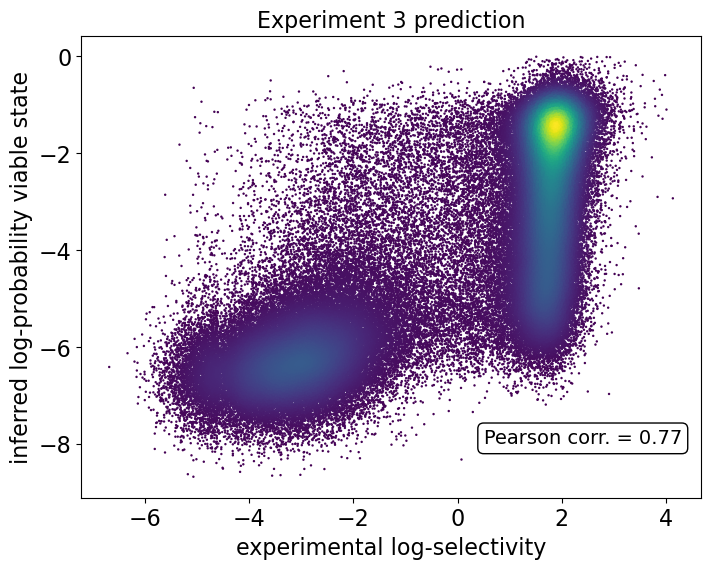

In [52]:
figure(figsize=(8,6))
plot_density(θexperiment3, ls_experiment3_filtered, filter=true)
title("Experiment 3 prediction", fontsize=16)
xlabel("experimental log-selectivity", fontsize=16)
ylabel("inferred log-probability viable state", fontsize=16)
text(0.5, -8,"Pearson corr. = $(round(cor_sp(θexperiment3, ls_experiment3_filtered), digits=2))", fontsize=14,
    bbox=Dict("boxstyle"=>"round", "facecolor"=>"white"))
xticks(fontsize=16)
yticks(fontsize=16)
savefig("../figures/exp3_prediction.pdf", format="pdf", bbox_inches="tight", dpi=150)

### Choosing the threshold in an unsupervised manner

In [53]:
energies_exp12 = 
    energies(data_experiments.sequences, model_pt.states[2]);

In [54]:
#takes a lot of time you can just load them
#energies_exp3 = energies(data_experiment3.sequences[:,:,data_experiment3.counts[:, 1].>=100], model_pt.states[2])
@load "energies_exp3.jld2"

1-element Vector{Symbol}:
 :energies_exp3

In [55]:
μeff1 = model_pt.μ[2,1] - model_pt.μ[1,1]
μeff2 = model_pt.μ[2,2] - model_pt.μ[1,2]

-0.3777402833144671

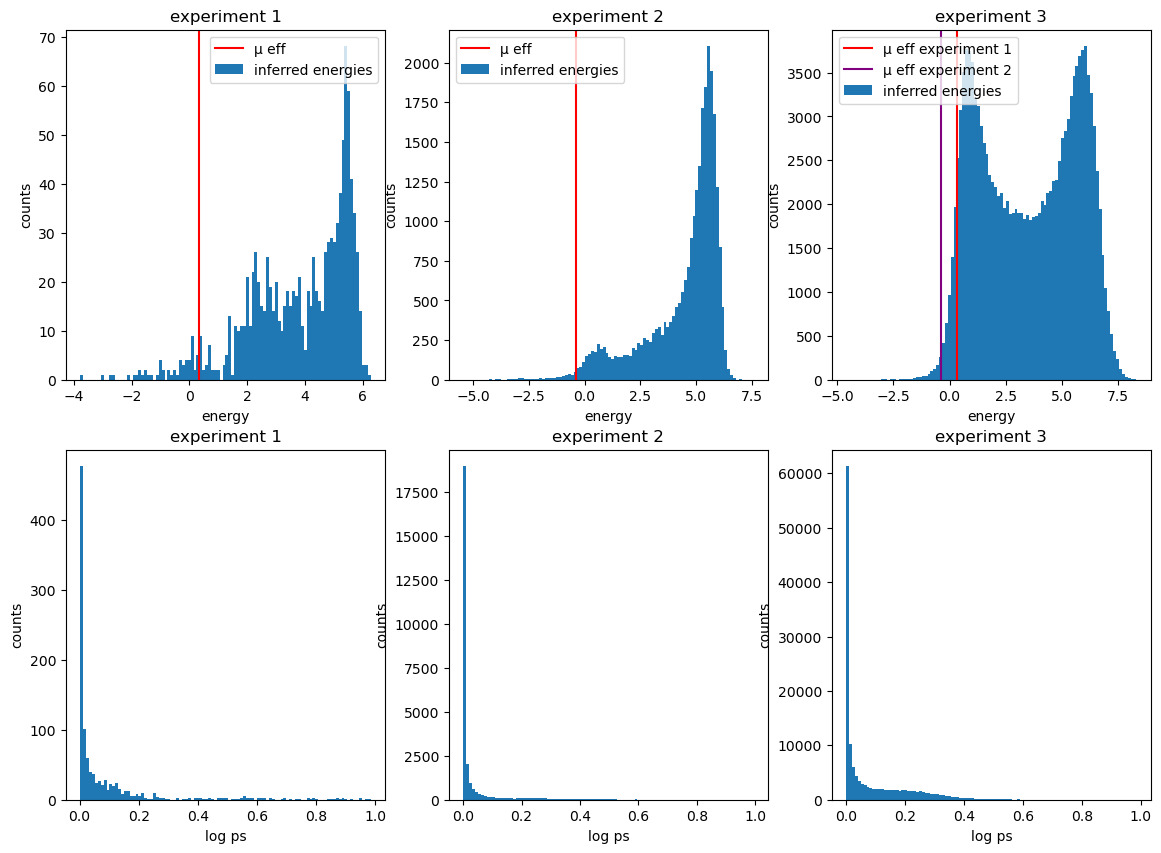

In [56]:
fig, ax = subplots(2,3, figsize=(14,10))
ax[1,1].axvline(μeff1, color="red")
ax[1,1].hist(energies_exp12[union(idx_exp1, idx_exp12)], bins=100)
ax[1,1].set_xlabel("energy")
ax[1,1].set_ylabel("counts")
ax[1,1].set_title("experiment 1")
ax[1,1].legend(["μ eff", "inferred energies"])

ax[1,2].axvline(μeff2, color="red")
ax[1,2].hist(energies_exp12[union(idx_exp2, idx_exp12)], bins=100)
ax[1,2].set_xlabel("energy")
ax[1,2].set_ylabel("counts")
ax[1,2].set_title("experiment 2")
ax[1,2].legend(["μ eff", "inferred energies"])

ax[1,3].axvline(μeff1, color="red")
ax[1,3].axvline(μeff2, color="purple")
ax[1,3].hist(energies_exp3, bins=100)
ax[1,3].set_xlabel("energy")
ax[1,3].set_ylabel("counts")
ax[1,3].set_title("experiment 3")
ax[1,3].legend(["μ eff experiment 1", "μ eff experiment 2", "inferred energies"])

ax[2,1].hist(exp.(ls_experiments[union(idx_exp1, idx_exp12)]), bins=100)
ax[2,1].set_xlabel("log ps")
ax[2,1].set_ylabel("counts")
ax[2,1].set_title("experiment 1")

ax[2,2].hist(exp.(ls_experiments[union(idx_exp2, idx_exp12)]), bins=100)
ax[2,2].set_xlabel("log ps")
ax[2,2].set_ylabel("counts")
ax[2,2].set_title("experiment 2")

ax[2,3].hist(exp.(ls_experiment3_filtered), bins=100)
ax[2,3].set_xlabel("log ps")
ax[2,3].set_ylabel("counts")
ax[2,3].set_title("experiment 3");

In [57]:
gmm = GMM(2,1)
gmm.μ .+= randn(2,1)
gmm.Σ .*= 1e-1;

In [58]:
em!(gmm, Float64.(reshape(energies_exp3, :, 1)); nIter=120)

120-element Vector{Float64}:
 -62.86080929155979
  -2.1972255111269607
  -2.1903617261504826
  -2.1865460935371863
  -2.1806540230332114
  -2.1707999554694544
  -2.1573788893431685
  -2.1437242464731705
  -2.1326231267536873
  -2.124023338586412
  -2.1169571888150496
  -2.110859600160545
  -2.105514718952079
   ⋮
  -2.0458748854961226
  -2.0458744821941
  -2.045874122822392
  -2.0458738025990084
  -2.0458735172619775
  -2.0458732630128833
  -2.045873036466509
  -2.0458728346059627
  -2.045872654742637
  -2.0458724944805393
  -2.045872351684477
  -2.045872224451697

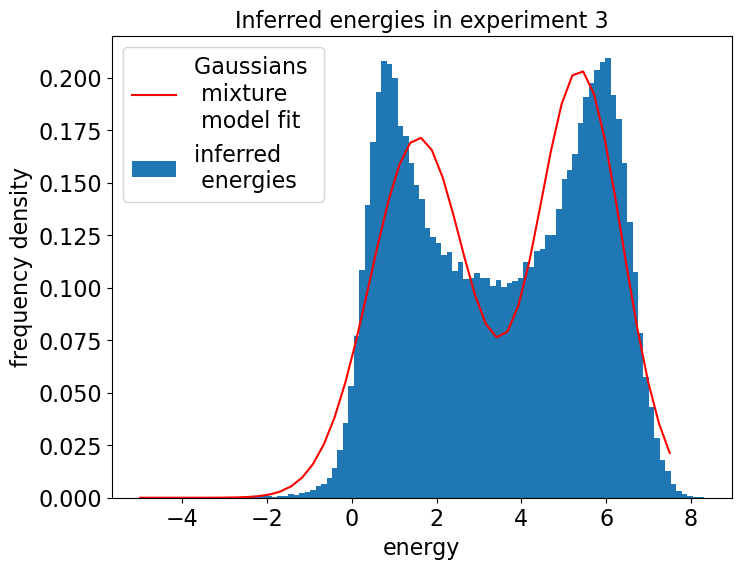

In [59]:
xx = LinRange(-5.0, 7.5, 50)
figure(figsize=(8,6))
hist(energies_exp3, bins=100, density=true)
plot(xx, eval_gmm(gmm, xx), color="red")
xlabel("energy", fontsize=16)
ylabel("frequency density", fontsize=16)
legend(["Gaussians \n mixture \n model fit", "inferred \n energies"], fontsize=16)
title("Inferred energies in experiment 3", fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
savefig("../figures/exp3_energy_fit.pdf", format="pdf", bbox_inches="tight")

In [60]:
function find_valley(gmm, resolution::Int)
    xmin = gmm.μ[1,1]
    xmax = gmm.μ[2,1]
    r = LinRange(xmin, xmax, resolution)
    y = eval_gmm(gmm, r)
    xvalley = argmin(y)
    return r[xvalley]
end

find_valley (generic function with 1 method)

In [61]:
find_valley(gmm, 100)

3.457014289547737

In [62]:
unsupervised_energy_threshold = 3.458437571261687

3.458437571261687

In [63]:
println("testing accuracy on experiment 3: ",
compute_accuracy(-energies_exp3, -unsupervised_energy_threshold, θexperiment3, threshold_experiment3))

testing accuracy on experiment 3: 0.8107356684727733


In [64]:
println("confusion matrix \n")
confusion_mat_unsupervised_exp3 = confusion_matrix(-energies_exp3, -unsupervised_energy_threshold, θexperiment3, threshold_experiment3)

confusion matrix 

TP: 58964	 FN: 17346
FP: 9271	 TN: 55053

(tpr = 0.7726903420259468, fpr = 0.1441297183011007)

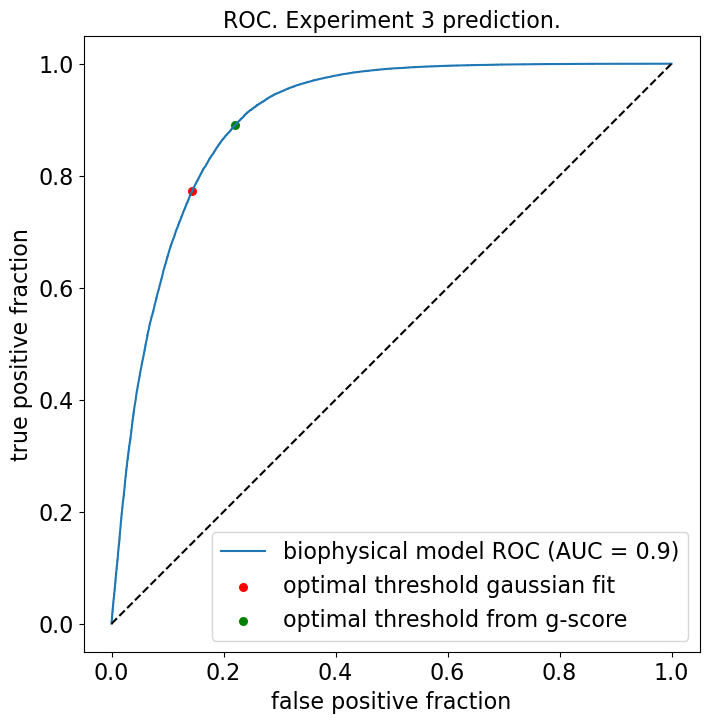

In [65]:
figure(figsize=(8,8))
plot(false_pos_pt, true_pos_pt)
scatter([confusion_mat_unsupervised_exp3.fpr], [confusion_mat_unsupervised_exp3.tpr], s=30, color="red")
scatter([confusion_mat_gscore_exp3.fpr], [confusion_mat_gscore_exp3.tpr], s=30, color="green")
plot([0,1],[0,1], color="black", linestyle="dashed")
title("ROC. Experiment 3 prediction.", fontsize=16)
xlabel("false positive fraction", fontsize=16)
ylabel("true positive fraction", fontsize=16)
legend(["biophysical model ROC (AUC = $(round(auc_val_pt, digits=2)))", "optimal threshold gaussian fit", "optimal threshold from g-score"], fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
ax = gca()
ax.set_aspect("equal")
savefig("../figures/exp3_roc_points.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#=
saving useful data to print logos


sequences_int_exp3 = [[findfirst(sequences_experiment3[:, i, 1, k] .> 0.0) 
        for i in axes(sequences_experiment3, 2)] for k in axes(sequences_experiment3, 4)]
sequences_int_exp12 = [[findfirst(data_experiments.sequences[:, i, k] .> 0.0) 
        for i in axes(data_experiments.sequences, 2)] for k in axes(data_experiments.sequences, 3)]
@save "logos/data_for_logos.jld2" sequences_int_exp3 sequences_int_exp12 energies_exp3 unsupervised_energy_threshold θexperiment3 threshold_experiment3 ls_experiment3_filtered ls_threshold
=#

# Distance analysis

In [66]:
file_exp1 = load("../my_data/data_experiment1.jld2")

Dict{String, Any} with 3 entries:
  "wt_aa"                 => "DEEEIRTTNPVATEQYGSVSTNLQRGNR"
  "sequences_experiment1" => ["DEELIRTTNPVATEQYGSVSTNLQRGNR", "DEEEIYTTNPVATEQY…
  "counts_experiment1"    => [1439 349; 2829 3326; … ; 2053 6849; 4249 409]

In [67]:
wt_aa = file_exp1["wt_aa"]

"DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [68]:
sequences_string_experiment3 = onehot2string(sequences_experiment3, channel=true, padding=false);

In [69]:
distances = map(x->evaluate(Levenshtein(), x, wt_aa), sequences_string_experiment3);

In [70]:
dmin, dmax = extrema(distances)

(3, 29)

In [71]:
accuracy_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        accuracy_distance[i] = NaN
        continue
    end
    accuracy_distance[i] = compute_accuracy(logits_experiment3[idx], 0.0, θexperiment3[idx], threshold_experiment3)
end

In [72]:
accuracy_distance_energy = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        accuracy_distance_energy[i] = NaN
        continue
    end
    accuracy_distance_energy[i] = compute_accuracy(-energies_exp3[idx], -unsupervised_energy_threshold, 
        θexperiment3[idx], threshold_experiment3)
end

In [73]:
pearson_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        pearson_distance[i] = NaN
        continue
    end
    pearson_distance[i] = cor_sp(θexperiment3[idx], ls_experiment3_filtered[idx])
end

In [74]:
viable_frac = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        viable_frac[i] = NaN
        continue
    end
    viable_frac[i] = sum(θexperiment3[idx] .>= threshold_experiment3)/length(idx)
end

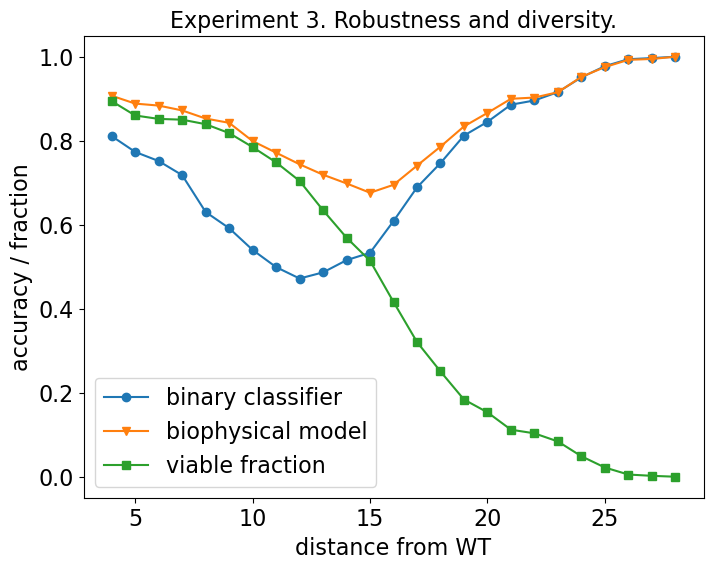

In [75]:
figure(figsize=(8,6))
plot(dmin:dmax, accuracy_distance, marker="o", color="#1f77b4")
plot(dmin:dmax, accuracy_distance_energy, marker="v", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["binary classifier", "biophysical model", "viable fraction"], fontsize=16)
ylabel("accuracy / fraction", fontsize=16)
xlabel("distance from WT", fontsize=16)
title("Experiment 3. Robustness and diversity.", fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
savefig("../figures/exp3_distance_accuracy.pdf", format="pdf", bbox_inches="tight")

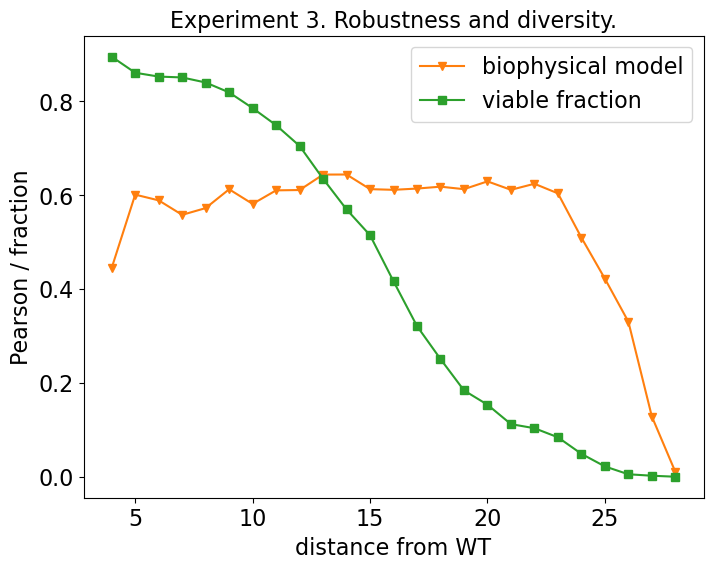

In [76]:
figure(figsize=(8,6))
plot(dmin:dmax, pearson_distance, marker="v", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["biophysical model", "viable fraction"], fontsize=16)
ylabel("Pearson / fraction", fontsize=16)
xlabel("distance from WT", fontsize=16)
title("Experiment 3. Robustness and diversity.", fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
savefig("../figures/exp3_distance_pearson.pdf", format="pdf", bbox_inches="tight")